In [98]:
import pandas as pd
import pickle
from keras import Sequential
from keras.layers import LSTM, SimpleRNN, GRU, Dense
from keras.losses import SparseCategoricalCrossentropy
from keras.callbacks import EarlyStopping
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
import os
from sklearn.metrics import precision_recall_fscore_support

## Goal

Given the past day of data, predict the largest flare in the next day. In the file `dataWrangling.py`, we read, parse, and split data into training and testing sets.

In [99]:
def loadPickledFile(fileName):
    bytes_in = bytearray(0)
    max_bytes = 2**31 - 1
    input_size = os.path.getsize(fileName)
    with open(fileName, 'rb') as file:
        for _ in range(0, input_size, max_bytes):
            bytes_in += file.read(max_bytes)
        obj = pickle.loads(bytes_in)
        file.close()
    return obj

In [100]:
# X_train = loadPickledFile("timeseries_encoded/X_train.pck")
# X_test = loadPickledFile("timeseries_encoded/X_test.pck")
# y_train = loadPickledFile("timeseries_encoded/y_train.pck")
# y_test = loadPickledFile("timeseries_encoded/y_test.pck")

X_train = loadPickledFile("timeseries/X_train.pck")
X_test = loadPickledFile("timeseries/X_test.pck")
y_train = loadPickledFile("timeseries/y_train.pck")
y_test = loadPickledFile("timeseries/y_test.pck")

KeyboardInterrupt: 

In [ ]:
y_train.shape

(343131, 1, 1)

In [ ]:
num_features = X_train[0].shape[1]
num_classes = 5
model = Sequential()
# Input Layer
# model.add(Dense(num_features, input_shape=(dataPointsPerX, num_features),activation='relu'))
model.add(Dense(num_features, input_shape=X_train[0].shape,activation='relu'))
# Hidden Layers: RNN
model.add(LSTM(units=2*num_features, return_sequences=True)) # Add return_sequences=True if you want to add more architecture
model.add(GRU(units=2*num_features, return_sequences=True))
model.add(SimpleRNN(units=2*num_features))
# Output Layer
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss=SparseCategoricalCrossentropy())
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 120, 6)            42        
                                                                 
 lstm_8 (LSTM)               (None, 12)                912       
                                                                 
 dense_17 (Dense)            (None, 5)                 65        
                                                                 
Total params: 1019 (3.98 KB)
Trainable params: 1019 (3.98 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
display(y_train[0].shape)
model.predict(np.array([X_train[0]])).shape

display(y_train.shape)
display(X_train.shape)

(1, 1)

1/1 [==============================] - 1s 950ms/step


(343131, 1, 1)

(343131, 120, 6)

In [ ]:
X_sub = X_train[0:100]
y_sub = y_train[0:100]

epochs = 25
val_split = 0.2
model.fit(X_train,
          y_train,
          validation_split=val_split,
          epochs=epochs,
          verbose=1,
          callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
          shuffle=True)
# model.fit(X_sub,
#           y_sub,
#           validation_split=val_split,
#           epochs=epochs,
#           verbose=1,
#           callbacks=[EarlyStopping(monitor='val_loss', patience=2)],
#           shuffle=False)

Epoch 1/10
8579/8579 [==============================] - 247s 28ms/step - loss: 0.3391 - val_loss: 0.3333
Epoch 2/10
8579/8579 [==============================] - 240s 28ms/step - loss: 0.3212 - val_loss: 0.3447
Epoch 3/10
8579/8579 [==============================] - 239s 28ms/step - loss: 0.3178 - val_loss: 0.3377


In [ ]:
modelName = "LSTM-GRU-RNN"
model.save(f"persisted_nets/{modelName}")

INFO:tensorflow:Assets written to: persisted_nets/simpleLSTM\assets


INFO:tensorflow:Assets written to: persisted_nets/simpleLSTM\assets


In [ ]:
classLabels = {
    0: "0",
    1: "B",
    2: "C",
    3: "M",
    4: "X"
}

def threshold_output(output):
    thresholded = []
    for arr in output:
        thresholded.append(np.array([np.array([np.argmax(arr)])]))
    return np.array(thresholded)
    

y_pred = model.predict(X_test)
y_pred = threshold_output(y_pred)

p,r,f,s = precision_recall_fscore_support(y_test.flatten(), y_pred.flatten())

def printMetrics(p,r,f,s):
    for i in range(len(p)):
        print(f"Metrics for {classLabels[i]} class flares")
        print(f"\tPrecision: {p[i]}")
        print(f"\tRecall:    {r[i]}")
        print(f"\tF-Score:   {f[i]}")
        print(f"\tSupport:   {s[i]}")

printMetrics(p,r,f,s)
# X_train[0]

4596/4596 [==============================] - 31s 7ms/step
Metrics for 0 class flares
	Precision: 0.9228951551692038
	Recall:    0.984065418063265
	F-Score:   0.9524991963107894
	Support:   130973
Metrics for B class flares
	Precision: 0.0
	Recall:    0.0
	F-Score:   0.0
	Support:   2109
Metrics for C class flares
	Precision: 0.4277832791059556
	Recall:    0.2615916955017301
	F-Score:   0.324655107627892
	Support:   11560
Metrics for M class flares
	Precision: 0.10256410256410256
	Recall:    0.016537467700258397
	F-Score:   0.02848242100578549
	Support:   1935
Metrics for X class flares
	Precision: 0.0
	Recall:    0.0
	F-Score:   0.0
	Support:   480


c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


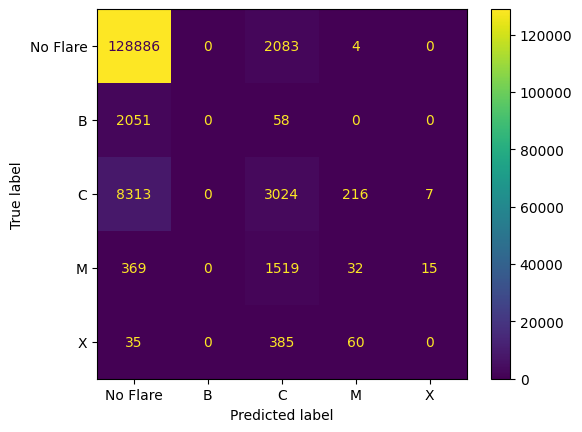

In [ ]:
disp = ConfusionMatrixDisplay.from_predictions(y_test.flatten(), y_pred.flatten(), display_labels=["No Flare", "B", "C", "M", "X"])